In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import time

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

from src.ForecestModel.data.models import DataModelCV
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [3]:
model_handle =  ModelHandler("PBHM-HLSTM",
                           r"F:\11_EFFORS\python\models\20240617_PBHM-HLSTM-MSE-min_max",
                           is_final_model = True,
                           color = "#a65628",
                           ls = "-",
                          )

## load model and data

In [4]:
# define fold/year to evaluate
n_fold = 4
year   = 2013 + n_fold # year 2017

# load datamodel
dm = DataModelCV(DATA_PATH,
       target_name       = model_handle.target_name,
       hincast_features  = model_handle.feat_hindcast,
       forecast_features = model_handle.feat_forecast,
     )

# load trial data
with open(os.path.join(model_handle.hp_path, "trial.json")) as f:
    trial = json.load(f)

hindcast_length = trial['hyperparameters']['values']['hindcast_length']

dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

# load dataset
X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

# load model
tf.keras.backend.clear_session()
keras_save_file_path = os.path.join(model_handle.hp_path, f"model_fold_{n_fold:d}.keras")
model  = tf.keras.models.load_model(keras_save_file_path,
                               custom_objects={'peak_loss'    : loss_peak_mse,  # dummy as no costum functions are saved by keras
                                              'loss_nkge_nnse': loss_peak_mse}) #

# get baseline input
X_base = tf.zeros_like(X[0])


dictonary loaded


## Analyse main peak flood event 2017

Text(0.5, 0, 'forecast step')

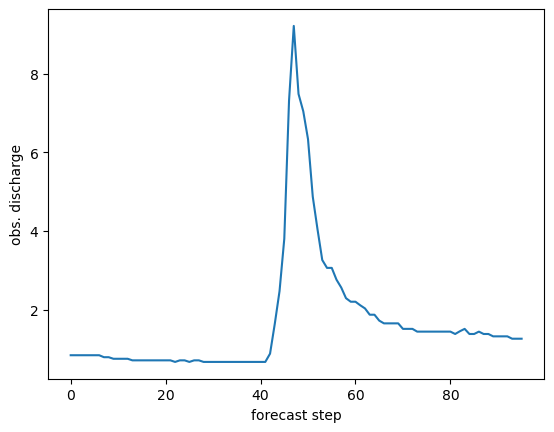

In [5]:
# find index of maximum flood event
idx  = np.argmax(np.max(y, axis=1), axis=0)[0]

# show analyzed flood event
plt.plot(y[idx+48])
plt.ylabel("obs. discharge")
plt.xlabel("forecast step")

In [6]:
# initalize
m   = 100 # number of lamellas to approximate integral, m=100 for results - m=1 for testing
plot_intermediate = False

ig0 = 0 # ig sum for hindcasts
ig1 = 0 # ig sum for forecasts
df = pd.DataFrame()
for offset in range(96):
    print(offset)
    
    X_tensor_0 = tf.convert_to_tensor(X[0][[idx+offset],:,:], dtype=tf.float32)
    X_tensor_1 = tf.convert_to_tensor(X[1][[idx+offset],:,:], dtype=tf.float32)
    
    base_tensor_0 = tf.zeros_like(X_tensor_0)
    base_tensor_1 = tf.zeros_like(X_tensor_1)
    
    offset_tensor_0 = (X_tensor_0 - base_tensor_0) / tf.constant(m, dtype=tf.float32)
    offset_tensor_1 = (X_tensor_1 - base_tensor_1) / tf.constant(m, dtype=tf.float32)
    
    for k in range(1, m+1):
        inp_tensor_0 = X_tensor_0 + tf.constant(k, dtype=tf.float32) * offset_tensor_0
        inp_tensor_1 = X_tensor_1 + tf.constant(k, dtype=tf.float32) * offset_tensor_1
        inp_tensor_list = [inp_tensor_0 , inp_tensor_1]
    
        with tf.GradientTape() as t:
            t.watch(inp_tensor_0)
            t.watch(inp_tensor_1)
            output = tf.math.reduce_max(model(inp_tensor_list), axis=1) # analysis at model output peak 
            #output = model(inp_tensor_list)[:, offset] # analysis at flood event peak 

        grad_0, grad_1 = t.gradient(output, inp_tensor_list)
        
        if k == 1:
            total_grad_0 = grad_0
            total_grad_1 = grad_1
        else:
            total_grad_0 += grad_0
            total_grad_1 += grad_1
    
    integrated_grad_0 = offset_tensor_0 * total_grad_0
    integrated_grad_1 = offset_tensor_1 * total_grad_1

    df.loc[offset, ["h_" + x for x in model_handle.feat_hindcast]] = np.sum(np.sum(np.abs(integrated_grad_0), axis=0), axis=0)
    df.loc[offset, ["f_" + x for x in model_handle.feat_forecast]] = np.sum(np.sum(np.abs(integrated_grad_1), axis=0), axis=0)

    # total sum 
    ig0 += np.sum(np.sum(np.abs(integrated_grad_0), axis=0), axis=0)
    ig1 += np.sum(np.sum(np.abs(integrated_grad_1), axis=0), axis=0)

    if ~plot_intermediate:
        continue

    # plot intermediate results
    fig,axes = plt.subplots(5,2, figsize=(20,10))
    for n in range(5):
        if n == 0:
            axes[n,0].set_title(r"$\bf{hindcast\ features}$")
        axes[n,0].fill_between(np.arange(96), 
                           np.mean(np.abs(integrated_grad_0[:,:,n]), axis=0), 
                           #np.max(integrated_grad_0[:,:,n], axis=0), 
                           alpha=0.25, color="k")
        axes[n,0].plot(np.mean(np.abs(integrated_grad_0[:,:,n]), axis=0), 
                   c="k", lw=2, label = model_handle.feat_hindcast[n])
        axes[n,0].grid(True)
        axes[n,0].set_xticks([0] + [x for x in range(11,98,12)])
        axes[n,0].set_ylim(0,4)
        axes[n,0].set_xlim(0,hindcast_length-1)
        axes[n,0].set_xlabel("input sequence step")
        axes[n,0].set_ylabel("node importance")
        axes[n,0].legend()
    
    
    for n in range(4):
        if n == 0:
            axes[n,1].set_title(r"$\bf{forecast\ features}$")
        axes[n,1].fill_between(np.arange(96), 
                           np.mean(np.abs(integrated_grad_1[:,:,n]), axis=0), 
                           #np.max(integrated_grad_1[:,:,n], axis=0), 
                           alpha=0.25, color="k")
        axes[n,1].plot(np.mean(np.abs(integrated_grad_1[:,:,n]), axis=0), 
                   c="k", lw=2, label = model_handle.feat_forecast[n])
        axes[n,1].grid(True)
        axes[n,1].set_xticks([0] + [x for x in range(11,98,12)])
        axes[n,1].set_ylim(0,4)
        axes[n,1].set_xlim(0,95)
        axes[n,1].set_xlabel("input sequence step")
        axes[n,1].set_ylabel("node importance")
        axes[n,1].legend()
    
    
    axes[4,1].fill_between(np.arange(96), 
                           y[idx+offset].flatten(),
                           alpha=0.25, color="b")
    axes[4,1].plot(y[idx+offset], c="b", label="obs. discharge")
    axes[4,1].set_ylim(0,15)
    axes[4,1].grid(True)
    axes[4,1].plot(yp[idx+offset,:], c="k", lw=2, label="LSTM output")
    axes[4,1].set_xticks([0] + [x for x in range(11,98,12)])
    axes[4,1].set_xticklabels([f"{int(x)+1:d}" for x in axes[4,1].get_xticks()])
    axes[4,1].set_xlim(0,95)
    axes[4,1].set_ylabel(r"discharge $m^3/s$")
    axes[4,1].set_xlabel("lead time step")
    axes[4,1].vlines([yp[idx+offset,:].argmax()], 0, 15, color="r", lw=3, ls="--", label="peak to evaluate gradients")
    axes[4,1].legend()
    axes[4,1].set_facecolor((0, 0, 0, 0.1))


    fig.tight_layout()
    fig.savefig(os.path.join(PLOT_PATH, f"ig_peak_2017-{offset:05d}.png"), bbox_inches="tight")
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [7]:
# save results
# df.to_pickle(r"src\rst\ig_flood_event_2017.pkl")

## summary of hindcast features - peak 2017

In [8]:
ig_sum_h = np.sum(np.sum(np.abs(integrated_grad_0), axis=0), axis=0)
ig_sum_h # sum of absolute gradients hindcast features

array([0.06471805, 0.05546029, 0.10856672, 0.06922345, 0.1314641 ],
      dtype=float32)

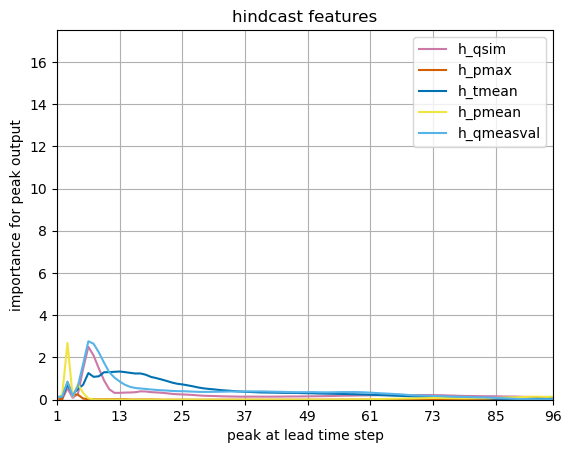

In [9]:
colors = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]

fig,ax = plt.subplots(1,1)
for n, col in enumerate([x for x in df.columns if x[0] == "h"]):
    ax.plot(df[col], c=colors[n], label=col)
    
ax.set_title("hindcast features")
ax.set_xlabel("peak at lead time step")
ax.set_ylabel("importance for peak output")
ax.set_xticks([0] + [x for x in range(11,98,12)])
ax.set_xticklabels([f"{int(95-x)+1:d}" for x in ax.get_xticks()])
ax.set_xlim([95,0])
ax.set_ylim([0,17.5])
plt.legend()
plt.grid()


In [10]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_peak_2017-hindcast_summary.png"), bbox_inches="tight")

## summary of forcast features - peak 2017

In [11]:
ig_sum_f = np.sum(np.sum(np.abs(integrated_grad_1), axis=0), axis=0)
ig_sum_f # sum of absolute gradients forecast features

array([2.9685168, 0.8179361, 3.2789402, 5.3011365], dtype=float32)

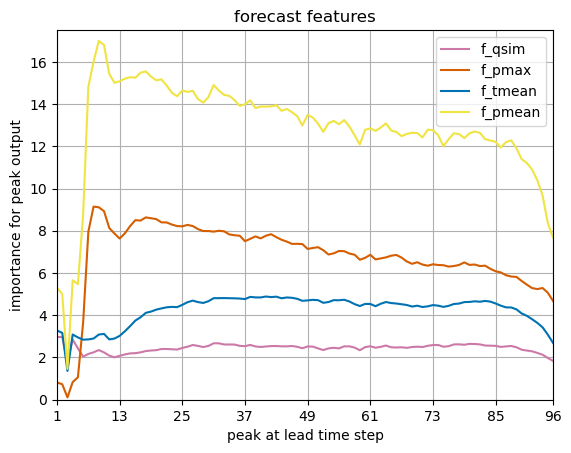

In [12]:
colors = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]

fig, ax = plt.subplots(1,1)
for n, col in enumerate([x for x in df.columns if x[0] == "f"]):
    ax.plot(df[col], c=colors[n], label=col)
    
ax.set_title("forecast features")
ax.set_xlabel("peak at lead time step")
ax.set_ylabel("importance for peak output")
ax.set_xticks([0] + [x for x in range(11,98,12)])
ax.set_xticklabels([f"{int(95-x)+1:d}" for x in ax.get_xticks()])
ax.set_xlim([95,0])
ax.set_ylim([0,17.5])
plt.legend()
plt.grid()

In [13]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_peak_2017-forecast_summary.png"), bbox_inches="tight")